#Импорт Библиотек и настройка профиля kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, TargetEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, make_scorer, f1_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


#Классификация

##Подготовка данных



###Скачивание датасета

In [ ]:
!kaggle datasets download -d shrutimechlearn/churn-modelling
!unzip churn-modelling

Dataset URL: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
License(s): unknown
churn-modelling.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  churn-modelling.zip
replace Churn_Modelling.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Churn_Modelling.csv     


###Исходные данные

In [ ]:
df = pd.read_csv("Churn_Modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Удалим идентификаторы не несущие полезной информации

In [ ]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1,inplace=True)

###Проверка наличия нулевых значений

In [ ]:
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


###Обработка категориальных признаков

Проверим количество уникальных значений категориальных признаков для выбора подходящего метода кодировки

In [ ]:
df.select_dtypes(include=["object"]).nunique()

,0
Geography,3
Gender,2


Так как категориальные признаки имеют маленькое количество уникальных значений применим кодировку One-Hot

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df, encoded], axis=1)
df.drop(categorical_columns, axis=1, inplace=True)

###Разделим датасет на train test и validation

In [ ]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(df.drop(columns="Exited"), df["Exited"], test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.2)

###Нормализация

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Сохраним данные обучения бейзлайна

In [ ]:
X_train_baseline, X_test_baseline, Y_train_baseline, Y_test_baseline = X_train, X_test, Y_train, Y_test

##Бейзлайн


In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1583
           1       0.69      0.20      0.31       417

    accuracy                           0.81      2000
   macro avg       0.75      0.59      0.60      2000
weighted avg       0.79      0.81      0.77      2000



##Улучшение бейзлайна

Для улучшения качества модели мы можем предпринять следующие шаги:
- Проверить баланс классов и использовать оверсемплинг для балансировки классов
- Подобрать оптимальные гиперпараметры

###Ресэмплинг

Text(0.5, 1.0, 'Распределение данных')

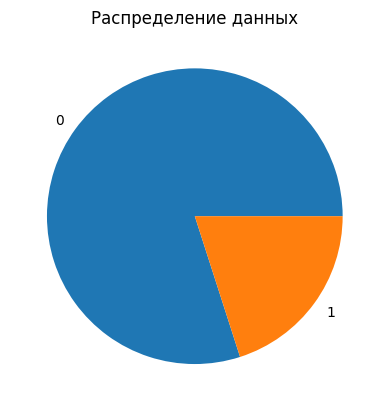

In [ ]:
plt.pie(Y_train.value_counts(), labels = ['0', '1'])
plt.title("Распределение данных")

Text(0.5, 1.0, 'Распределение данных после ресэмплинга')

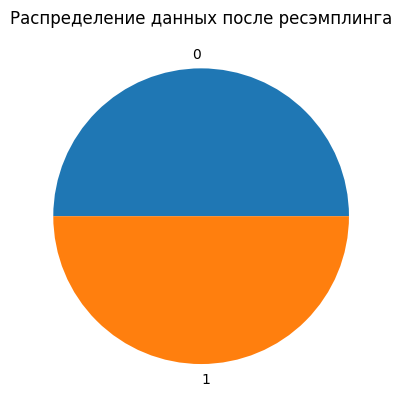

In [ ]:
sm = SMOTE()
X_train, Y_train = sm.fit_resample(X_train, Y_train)
plt.pie(Y_train.value_counts(), labels = ['0', '1'])
plt.title("Распределение данных после ресэмплинга")

In [ ]:
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_val)

f1 = f1_score(Y_val, Y_pred, pos_label=1)

print(classification_report(Y_val, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1263
           1       0.39      0.64      0.48       337

    accuracy                           0.71      1600
   macro avg       0.64      0.69      0.64      1600
weighted avg       0.78      0.71      0.73      1600

F1 (class 1): 0.48268156424581005


####Подбор гиперпараметров

In [ ]:
scorer = make_scorer(f1_score, pos_label=1)

params = {"max_iter":[100, 500, 1000, 5000], "penalty":[ "l2", None], "class_weight": ["balanced", None]}
grid = GridSearchCV(LogisticRegression(), params, cv=5, refit=True, scoring = scorer)
grid.fit(X_train, Y_train)
print(grid.best_params_, grid.best_score_)

{'class_weight': None, 'max_iter': 100, 'penalty': None} 0.7058579307172845


In [ ]:
Y_pred = grid.best_estimator_.predict(X_val)

f1 = f1_score(Y_val, Y_pred, pos_label=1)

print(classification_report(Y_val, Y_pred))
print("F1 (class 1):", f1)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1263
           1       0.39      0.64      0.48       337

    accuracy                           0.71      1600
   macro avg       0.64      0.69      0.64      1600
weighted avg       0.78      0.71      0.73      1600

F1 (class 1): 0.4849162011173184


###Улучшенный бейзлайн

In [ ]:
Y_pred = grid.best_estimator_.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1583
           1       0.41      0.73      0.53       417

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.67      2000
weighted avg       0.81      0.72      0.75      2000



##Собственная реализация логистической регрессии

In [ ]:
class MyLogisticRegressor:
    def __init__(self, lr = 0.01, max_iter = 100):
        self.max_iter = max_iter
        self.lr = lr

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for i in range(self.max_iter):
            pred = self._sigmoid(np.dot(X, self.weights) + self.bias)

            dw = (1 / n_samples) * np.dot(X.T, (pred - Y))
            db = (1 / n_samples) * np.sum(pred - Y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        X = np.asarray(X)
        # print(self._sigmoid(X @ self.weights + self.bias))
        return self._sigmoid(X @ self.weights + self.bias)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

Предсказание на данных бейзлайна

In [ ]:
classifier = MyLogisticRegressor()
classifier.fit(X_train_baseline, Y_train_baseline)
Y_pred = classifier.predict(X_test_baseline, threshold=0.32)
print(classification_report(Y_test_baseline, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.49      0.63      1583
           1       0.27      0.72      0.39       417

    accuracy                           0.54      2000
   macro avg       0.57      0.61      0.51      2000
weighted avg       0.74      0.54      0.58      2000



- Моя модель f1[1] = 0.39, accuracy = 0.54  
- sklearn f1[1] = 0.31, accuracy = 0.81\
 Моя модель показала лучший f1 но худшую общую точность

Предсказание на данных улучшенного бейзлайна

In [ ]:
classifier = MyLogisticRegressor()
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

[0.47353592 0.41754865 0.47587103 ... 0.47392915 0.49543052 0.52240386]
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1583
           1       0.34      0.60      0.44       417

    accuracy                           0.68      2000
   macro avg       0.61      0.65      0.60      2000
weighted avg       0.76      0.68      0.70      2000



- Моя модель f1[1] = 0.44, accuracy = 0.68  
- sklearn f1[1] = 0.53, accuracy = 0.72

#Регрессия

##Подготовка данных

###Скачивание датасета


In [ ]:
!kaggle datasets download -d jakewright/house-price-data
!unzip house-price-data.zip

Dataset URL: https://www.kaggle.com/datasets/jakewright/house-price-data
License(s): other
house-price-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-price-data.zip
replace kaggle_london_house_price_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: kaggle_london_house_price_data.csv  
replace kaggle_london_house_price_data.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: kaggle_london_house_price_data.parquet  


###Исходные данные

In [ ]:
reg_df = pd.read_csv("kaggle_london_house_price_data.csv")
reg_df

,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418196,"9 Harvard Road, London, SE13 6SE",SE13 6SE,England,SE13,51.452919,-0.010221,2.0,3.0,123.0,2.0,...,711000.0,HIGH,2025-01-10T11:04:57.114Z,27000.0,4.153846,2024-09-27,2024-09-27,650000,17.117117,95000.0
418197,"Lower Ground Floor Flat 5, Northwood Hall, Hor...",N6 5PE,England,N6,51.571692,-0.137007,1.0,2.0,60.0,1.0,...,473000.0,HIGH,2025-01-10T11:04:57.114Z,10000.0,2.272727,2024-09-27,2024-09-27,440000,2.325581,10000.0
418198,"17 Merritt Road, London, SE4 1DU",SE4 1DU,England,SE4,51.456054,-0.035073,2.0,3.0,100.0,1.0,...,853000.0,HIGH,2025-01-10T11:04:57.114Z,38000.0,4.909561,2024-09-27,2024-09-27,774000,128.655835,435500.0
418199,"15 Chester Row, London, SW1W 9JF",SW1W 9JF,England,SW1W,51.493587,-0.152122,3.0,4.0,218.0,2.0,...,5975000.0,MEDIUM,2025-01-10T11:04:57.114Z,-818000.0,-13.088000,2024-09-27,2024-09-27,6250000,73.611111,2650000.0


Удалим нижние и верхние оценки цены и оценки аренды для избежания утечек данных. Также удалим столбцы указывающие на адрес, так как в датасете присктствуют стодбцы "lattitude"  и "longitude" более точно указывающие на местоположение дома.

In [ ]:
reg_df = reg_df.drop(["rentEstimate_lowerPrice", "rentEstimate_currentPrice", "rentEstimate_upperPrice", "saleEstimate_lowerPrice", "saleEstimate_upperPrice", "country", "fullAddress", "postcode", "outcode"], axis = 1)

###Проверим наличие нулевых значений и удалим содержащие и стоки
Набор данных очень большой, поэтому мы можем позволить себе удалить любые строки с нулевыми значениями без значительной потери данных.

In [ ]:
reg_df.isnull().sum()

,0
latitude,0
longitude,0
bathrooms,77931
bedrooms,40536
floorAreaSqM,25210
livingRooms,60500
tenure,11512
propertyType,1136
currentEnergyRating,84526
saleEstimate_currentPrice,640


In [ ]:
reg_df.dropna(how='any', axis=0, inplace=True)
reg_df.reset_index(drop=True, inplace=True)

###Кодирование категориальных признаков

Посмотрим количество уникальных значений для определения подходящего метода

In [ ]:
reg_df.select_dtypes(include=["object"]).nunique()

,0
tenure,4
propertyType,19
currentEnergyRating,7
saleEstimate_confidenceLevel,3
saleEstimate_ingestedAt,4
saleEstimate_valueChange.saleDate,3497
history_date,7394


Для признаков с маленьким количеством уникалтных значений применим кодировку One-Hot

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ["propertyType", "tenure"]
encoded = pd.DataFrame(encoder.fit_transform(reg_df.get(columns_to_encode)), columns=encoder.get_feature_names_out(columns_to_encode))
reg_df.drop(columns_to_encode, axis=1, inplace=True)
reg_df = pd.concat([reg_df, encoded], axis=1)

Для признаков, где порядок значений несет смысл применим порядковую кодировку.\
Посмотрим все возможные значения в столбцах и закодируем их по порядку

In [ ]:
reg_df["currentEnergyRating"].value_counts()

,count
currentEnergyRating,
D,68747
C,62568
E,13928
B,11112
F,715
G,125
A,83


In [ ]:
reg_df["saleEstimate_confidenceLevel"].value_counts()

,count
saleEstimate_confidenceLevel,
HIGH,132428
MEDIUM,20522
LOW,4328


In [ ]:
encoder = OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A'], ["LOW", "MEDIUM", "HIGH"]])
encoded = pd.DataFrame(encoder.fit_transform(reg_df.get(["currentEnergyRating","saleEstimate_confidenceLevel"])), columns=encoder.get_feature_names_out(["currentEnergyRating","saleEstimate_confidenceLevel"]))
reg_df["currentEnergyRating"] = encoded["currentEnergyRating"]
reg_df["saleEstimate_confidenceLevel"] = encoded["saleEstimate_confidenceLevel"]

Обработка даты и времени.\
Запмшем дату и время в целочисленном представлении

In [ ]:
reg_df["history_date"] = pd.to_datetime(reg_df["history_date"]).astype("int64")
reg_df["saleEstimate_valueChange.saleDate"] = pd.to_datetime(reg_df["saleEstimate_valueChange.saleDate"]).astype("int64")
reg_df["saleEstimate_ingestedAt"] = pd.to_datetime(reg_df["saleEstimate_ingestedAt"]).astype("int64")

###Разделим данные на train test и validation

In [ ]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(reg_df.drop("saleEstimate_currentPrice", axis=1), reg_df[["saleEstimate_currentPrice"]], test_size= 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size= 0.2)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

###Нормализация

In [ ]:
scaler = MinMaxScaler()
X_train = np.asarray(scaler.fit_transform(X_train))
X_test = np.asarray(scaler.transform(X_test))
X_val = np.asarray(scaler.transform(X_val))

In [ ]:
X_train_baseline, Y_train_baseline = X_train, Y_train
X_test_baseline, Y_test_baseline = X_test, Y_test
X_val_baseline, Y_val_baseline = X_val, Y_val

##Бейзлайн

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [ ]:
mae = mean_absolute_error(Y_pred, Y_test)
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)
print("MAE = ", mae)
print("MSE = ", mse)
print("R2 = ", r2)

MAE =  147845.97629425992
MSE =  93871796220.36177
R2 =  0.8132557926662962


##Собственная реализация линейной регрессии

In [ ]:
class MyLinearRegressor:
    def __init__(self, lr = 0.01, max_iter = 100):
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y)
        n, m = X.shape
        self.weights = np.zeros(m)
        self.bias = 0
        for i in range(self.max_iter):
            pred = np.dot(X, self.weights) + self.bias
            error = (pred - Y)

            w_grad = np.dot(X.T, error) * 2 / n
            b_grad = np.sum(error) * 2 / n

            self.weights -= self.lr * w_grad
            self.bias -= self.lr * b_grad

    def predict(self, X):
        X = np.asarray(X)
        return np.dot(X, self.weights.T) + self.bias

Так как Датасет имеет очень большой размер и моя  простая модель крайне нееффективна по времени, обучение будеn происходить на меньшей выборке из датасета

In [ ]:
idx = np.random.choice(X_train.shape[0], 1000, replace = False)
Y_train = np.asarray(Y_train).flatten()
X_train, Y_train = X_train[idx,:], Y_train[idx]

In [ ]:
regressor = MyLinearRegressor(max_iter = 500000)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mae = mean_absolute_error(Y_pred, Y_test)
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)
print("MAE = ", mae)
print("MSE = ", mse)
print("R2 = ", r2)

MAE =  186303.97332939235
MSE =  122857382783.62277
R2 =  0.7226172405361332


- Моя модель
    - MAE =  186303.97332939235
    - MSE =  122857382783.62277
    - R2  =  0.7226172405361332
- sklearn
    - MAE =  147845.97629425992
    - MSE =  93871796220.36177
    - R2  =  0.8132557926662962



###Вывод
Моя модель показала результаты сопоставимые с моделью sklearn, но при этом моя реализация очень простая. Более сложная реализация sklearn позволила ей получить более высокое качество предсказаний